In [1]:
import networkx as nx
PREF = 'all'
graph = nx.read_gexf('gexf/' + PREF + '_person_graph.gexf')
graph = max(nx.connected_component_subgraphs(graph), key=len)

## Network summary

###  Degree distribution, Shortest Path distribution, Diameter, Radius, Clustering Coefficients (local distribution and global)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

87


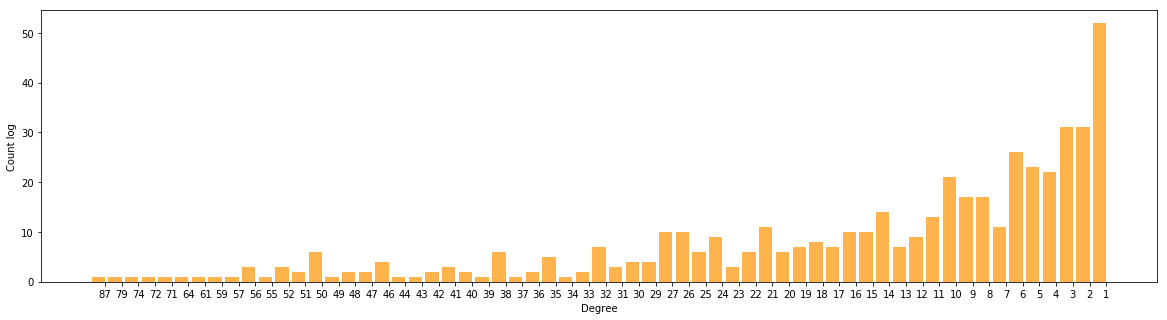

In [3]:
from collections import Counter
fig = plt.figure(figsize=(20, 5))
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(range(len(deg)), cnt, width=0.80, color=plt.cm.spring(0.7))
print(max(deg))
plt.ylabel("Count log")
plt.xlabel("Degree")
plt.xticks([d + 0.4 for d in range(len(deg))], deg)
#plt.yscale('log')
plt.show()
#fig.savefig('pdf/degree_hist.pdf')
fig.savefig('pdf/histograms/' + PREF + '_degree_hist.pdf')


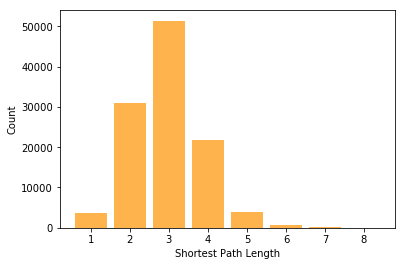

In [4]:
fig = plt.figure()
distance_dict = dict(nx.all_pairs_shortest_path_length(graph))
lengths_counter = Counter()
for i in distance_dict.keys():
    for j in distance_dict[i].keys():
        if distance_dict[i][j] > 0:
            lengths_counter.update((distance_dict[i][j], ))
            
path, cnt = zip(*lengths_counter.items())
cnt = list(map(lambda x: x // 2, cnt)) # each path is counter twice
plt.bar(path, cnt, width=0.80, color=plt.cm.spring(0.7))

plt.ylabel("Count")
plt.xlabel("Shortest Path Length")

plt.show()
fig.savefig('pdf/histograms/' + PREF + '_path_hist.pdf')

In [5]:
print('Diammeter %i, Radius %i' % (nx.diameter(graph), nx.radius(graph)))

Diammeter 8, Radius 4


#### Распределение количества выставок на человека

In [6]:
col_exh_cnt = [graph.nodes[node]['collective_exh_cnt'] for node in graph.nodes]

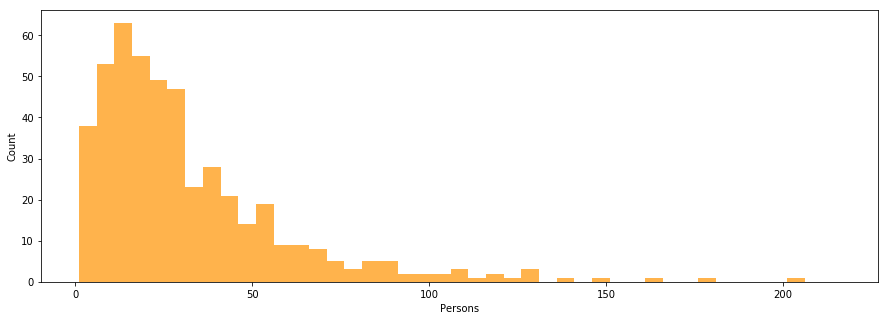

In [7]:
fig = plt.figure(figsize=(15, 5))

bins = range(1, 220, 5)
plt.hist(col_exh_cnt, bins=bins, log=False, color=plt.cm.spring(0.7))

plt.ylabel("Count")
plt.xlabel("Persons")

plt.show()
fig.savefig('pdf/histograms/' + PREF + '_col_exh_hist.pdf')

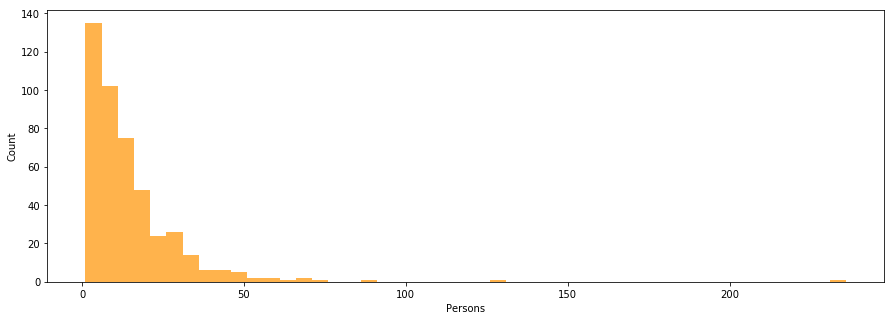

In [8]:
per_exh_cnt = [graph.nodes[node]['personal_exh_cnt'] for node in graph.nodes]
fig = plt.figure(figsize=(15, 5))

bins = range(1, 240, 5)
plt.hist(per_exh_cnt, bins=bins, log=False, color=plt.cm.spring(0.7))

plt.ylabel("Count")
plt.xlabel("Persons")

plt.show()
fig.savefig('pdf/histograms/' + PREF + '_pers_exh_hist.pdf')

#### Распределение количества выставок на галерею

In [9]:
import pickle
from collections import defaultdict

In [10]:
with open('data/galleries.pickle', 'rb') as f:
    galleries = pickle.load(f)

In [11]:
galleries_cnt = [len(galleries[key]) for key in galleries]

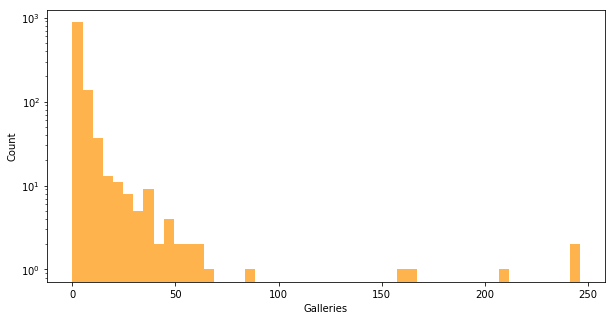

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.hist(galleries_cnt, bins=50, log=True, color=plt.cm.spring(0.7))
plt.ylabel("Count")
plt.xlabel("Galleries")

plt.show()
fig.savefig('pdf/histograms/' + PREF + '_galleries_hist.pdf')

#### Количество выставок в городах 

In [13]:
with open('data/' + PREF + '_artists_data.pickle', 'rb') as f:
    artists_data = pickle.load(f)

In [14]:
city_cnt = defaultdict(set)
for artist in artists_data:
        exhs = artist['personal_exh'] + artist['collective_exh']
        for exh in exhs:
            if 'city' in exh:
                city_cnt[exh['city'].strip()].add((exh['name'].lower(), exh['museum']))

In [15]:
city_cnt = [(key, len(city_cnt[key])) for key in city_cnt]
city_cnt = sorted(city_cnt, key=lambda x: -x[1])

In [16]:
import pandas as pd

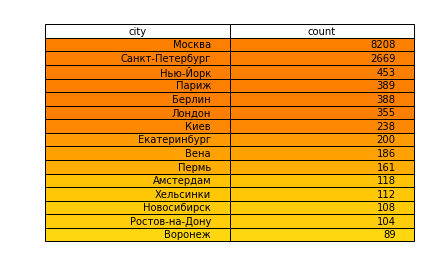

In [17]:
fig, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')
cm = plt.cm.Wistia
table = pd.DataFrame(city_cnt[:15], columns=['city', 'count'])
ax.table(cellText=table.values, cellColours=[[cm(x[1]), cm(x[1])] for x in city_cnt[:15]],
         colLabels=table.columns, loc='center')

fig.tight_layout()
plt.show()
fig.savefig('pdf/tables/' + PREF + '_cities_table.pdf')

#### Bar chart про процент иностранных выставок у топовых художников

In [18]:
with open('data/rus_artists_data.pickle', 'rb') as f:
    rus_artists_data = pickle.load(f)
with open('data/all_artists_data.pickle', 'rb') as f:
    all_artists_data = pickle.load(f)
    
top_artists = list(reversed(sorted([(len(a['personal_exh']), a['name']) for a in all_artists_data])))[:10]
top_artists_name = [x[1] for x in top_artists]
all_cnt = dict([(a[1], a[0]) for a in top_artists])
rus_top_artists = list(filter(lambda x: x['name'] in top_artists_name, rus_artists_data))
rus_cnt = dict([(a['name'].replace(' ', '\n', 1), len(a['personal_exh'])) for a in rus_top_artists])
foreign_cnt = dict([(a['name'].replace(' ', '\n', 1), all_cnt[a['name']] - rus_cnt[a['name'].replace(' ', '\n', 1)]) 
                    for a in rus_top_artists])
df = pd.DataFrame(columns=[x.replace(' ', '\n', 1) for x in top_artists_name]).append(rus_cnt, ignore_index=True).append(foreign_cnt, ignore_index=True)
df.index = ['russian', 'foreign']
df

Кабаковы\nИлья и Эмилия Черкашины\n Валера и Наташа Зинштейн\nАрон  \
russian                      21                          76             64   
foreign                     214                          54             23   

        Киселёва\nОльга Кантор\nМаксим Roiter\nAndrei Пепперштейн\nПавел  \
russian              12             13              3                 24   
foreign              59             53             63                 39   

        Михайлов\nБорис Мухин\nИгорь Молев\nАртур  
russian              18           31           45  
foreign              44           28           11

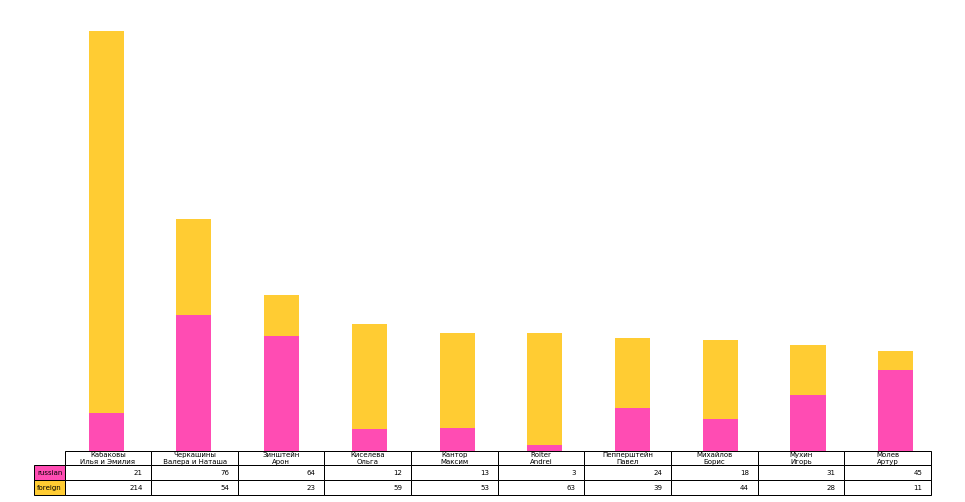

In [19]:
import numpy as np
fig, ax = plt.subplots(figsize=(18, 9))

ax.axis('off')

color = [plt.cm.spring(0.3), plt.cm.spring(0.8)]

table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, 
                 loc='bottom', rowColours=color, bbox=[0.019, -0.1, 0.955, 0.1])

table.auto_set_font_size(False)
table.set_fontsize(7)
index = np.arange(df.values.shape[1]) + 0.3
bar_width = 0.4
y_offset = np.zeros(df.values.shape[1])
for i, row in enumerate(df.values):
    plt.bar(index, row, bar_width, align='edge', bottom=y_offset, color=color[i])
    y_offset = y_offset + row
    
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Personal exhibitions count")
plt.xticks([])
fig.savefig('pdf/tables/foreign_and_rus_exh_table.pdf')

#### Распределение персональных выставок за рубежом

In [20]:
all_cnt = dict([(a['name'], len(a['personal_exh'])) for a in all_artists_data])
rus_cnt = dict([(a['name'], len(a['personal_exh'])) for a in rus_artists_data])
foreign_cnt = [all_cnt[a['name']] - rus_cnt[a['name']] if a['name'] in rus_cnt else 0 for a in all_artists_data]
foreign_cnt = list(filter(lambda x: x > 0, foreign_cnt))

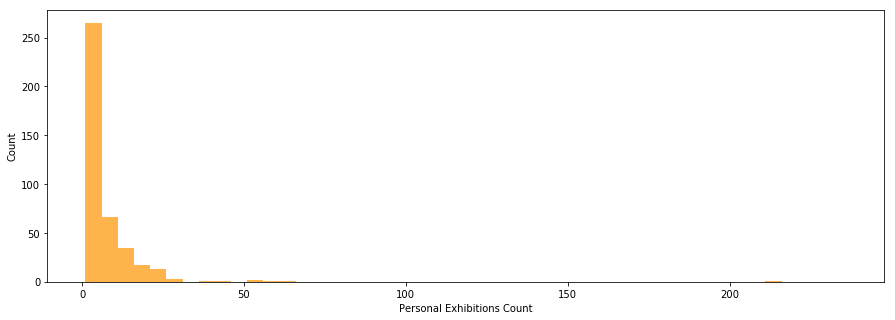

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.hist(foreign_cnt, bins=range(1, 240, 5), log=False, color=plt.cm.spring(0.7))
plt.ylabel("Count")
plt.xlabel("Personal Exhibitions Count")

plt.show()
fig.savefig('pdf/histograms/foreign_pers_hist.pdf')

#### Распределение коллективных выставок за рубежом

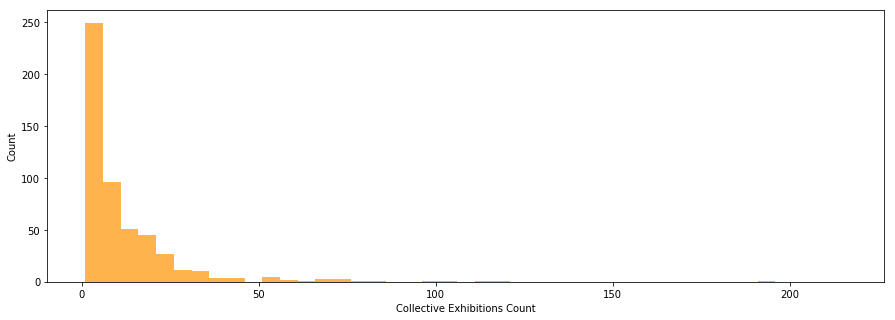

In [22]:
all_cnt = dict([(a['name'], len(a['collective_exh'])) for a in all_artists_data])
rus_cnt = dict([(a['name'], len(a['collective_exh'])) for a in rus_artists_data])
foreign_cnt = [all_cnt[a['name']] - rus_cnt[a['name']] if a['name'] in rus_cnt else 0 for a in all_artists_data]
foreign_cnt = list(filter(lambda x: x > 0, foreign_cnt))

fig = plt.figure(figsize=(15, 5))
plt.hist(foreign_cnt, bins=range(1, 220, 5), log=False, color=plt.cm.spring(0.7))
plt.ylabel("Count")
plt.xlabel("Collective Exhibitions Count")

plt.show()
fig.savefig('pdf/histograms/foreign_col_hist.pdf')

#### Количество выставок на зарубежную галерею 

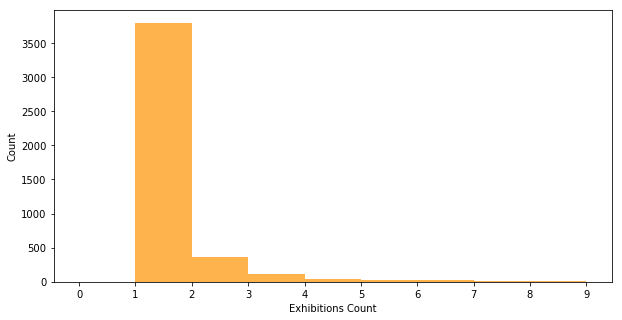

In [23]:
foreign_galleries = defaultdict(set)
for a in all_artists_data:
    exhs = a['personal_exh'] + a['collective_exh']
    for exh in exhs:
        if 'country' in exh and exh['country'] != 'Россия' and 'museum' in exh and exh['museum'] != '':
            foreign_galleries[(exh['country'], exh['museum'])].add(exh['name'])
cnt = [len(foreign_galleries[key]) for key in foreign_galleries]

fig = plt.figure(figsize=(10, 5))
plt.hist(cnt, log=False, bins=range(10), color=plt.cm.spring(0.7))
plt.ylabel("Count")
plt.xlabel("Exhibitions Count")
plt.xticks(range(10), range(10))
plt.show()
fig.savefig('pdf/histograms/foreign_galleries_hist.pdf')

## Structural analysis

### Centralities

In [90]:
from networkx.algorithms import centrality

In [91]:
degree_centrality = centrality.degree_centrality(graph)
nx.set_node_attributes(graph, degree_centrality, name='degree_centrality')

In [92]:
closeness_centrality = centrality.closeness_centrality(graph)
nx.set_node_attributes(graph, closeness_centrality, name='closeness_centrality')

In [93]:
betweenness_centrality = centrality.betweenness_centrality(graph)
nx.set_node_attributes(graph, betweenness_centrality, name='betweenness_centrality')

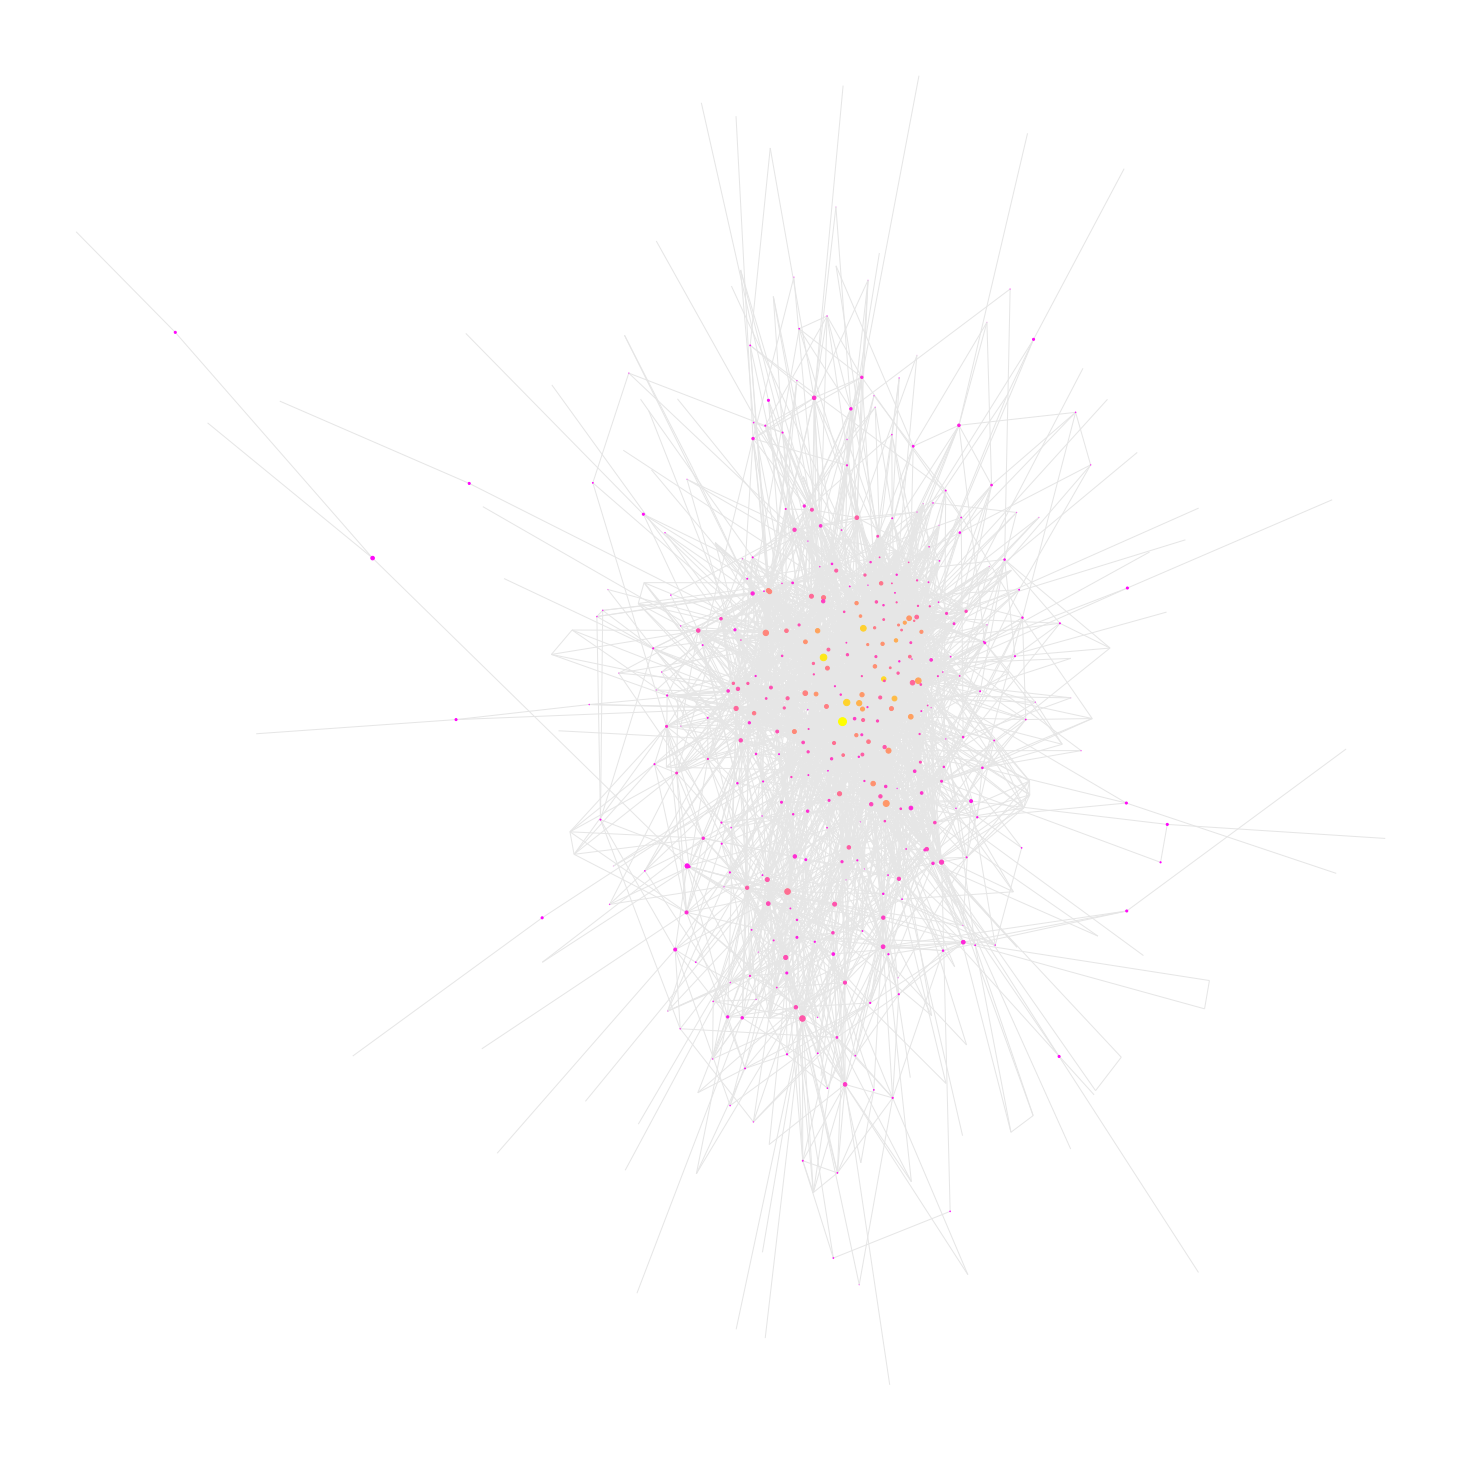

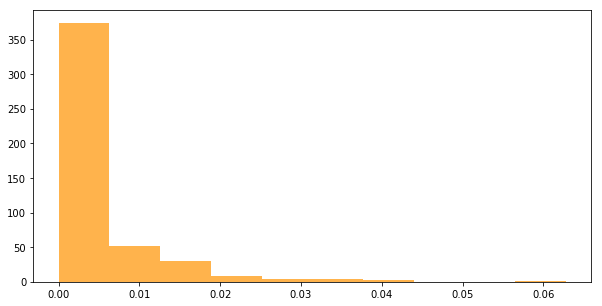

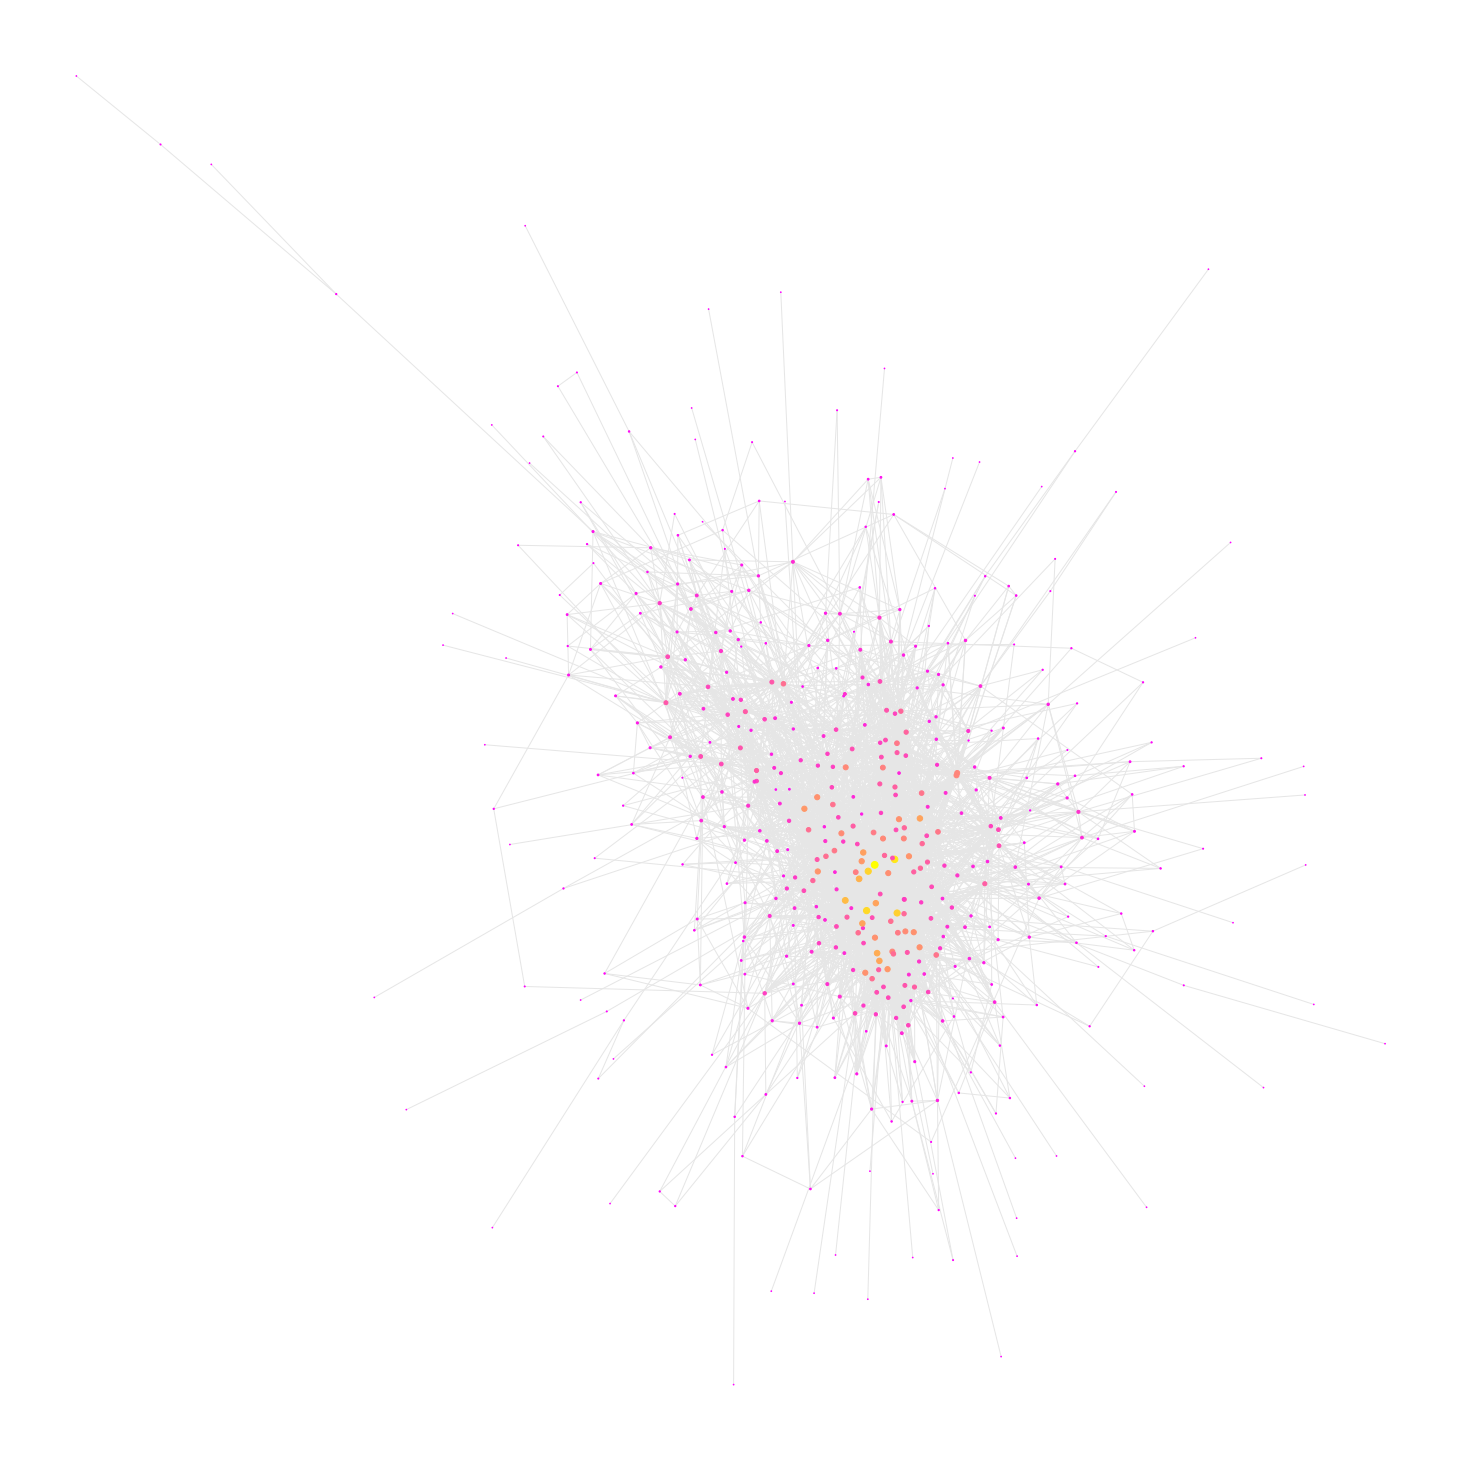

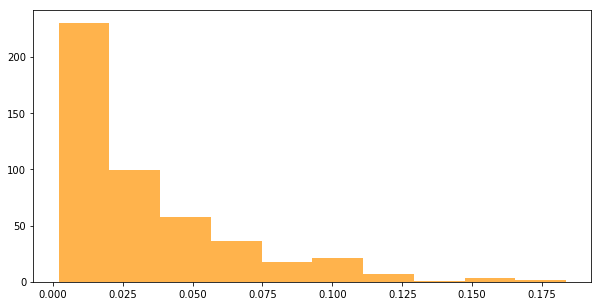

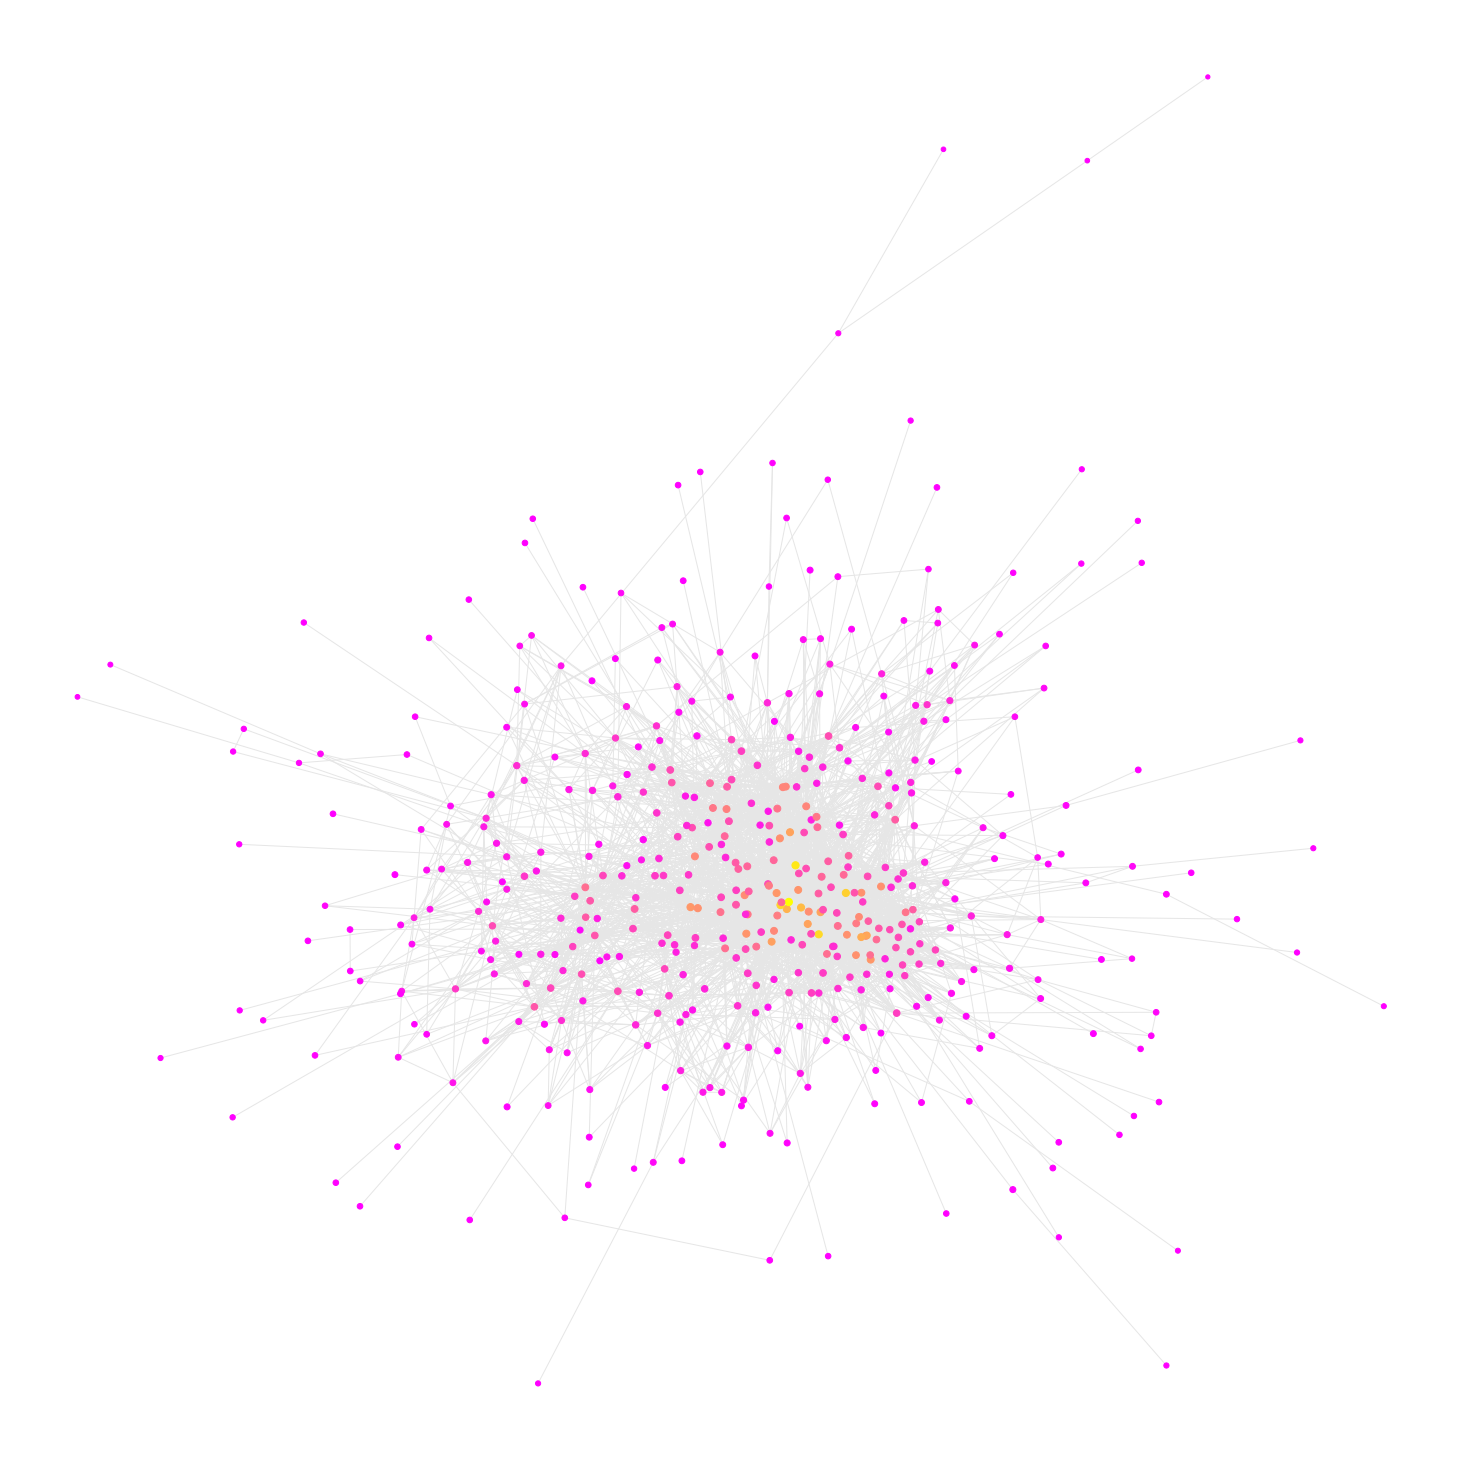

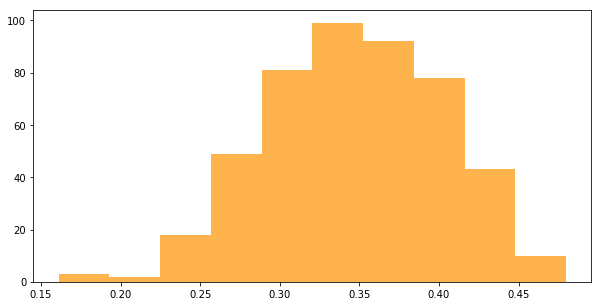

In [96]:
for i, metric in enumerate([betweenness_centrality, degree_centrality, closeness_centrality]):
    fig = plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size=[metric[v] * 1000 / (i + 1) ** 2 for v in graph], with_labels=False, 
            node_color=[len(graph[v]) for v in graph], cmap=plt.cm.spring, edge_color='0.9')
    fig.savefig('pdf/metrics/' + PREF + '_metric_' + str(i) +'.pdf')
    fig = plt.figure(figsize=(10, 5))
    plt.hist(list(metric.values()), color=plt.cm.spring(0.7))
    fig.savefig('pdf/histograms/' + PREF + '_metric_' + str(i) +'.pdf')

### Pagerank

In [29]:
#import networkx.algorithms.link_analysis.pagerank_alg.pagerank as nx_pagerank
pagerank = nx.pagerank(graph)
nx.set_node_attributes(graph, pagerank, name='pagerank')

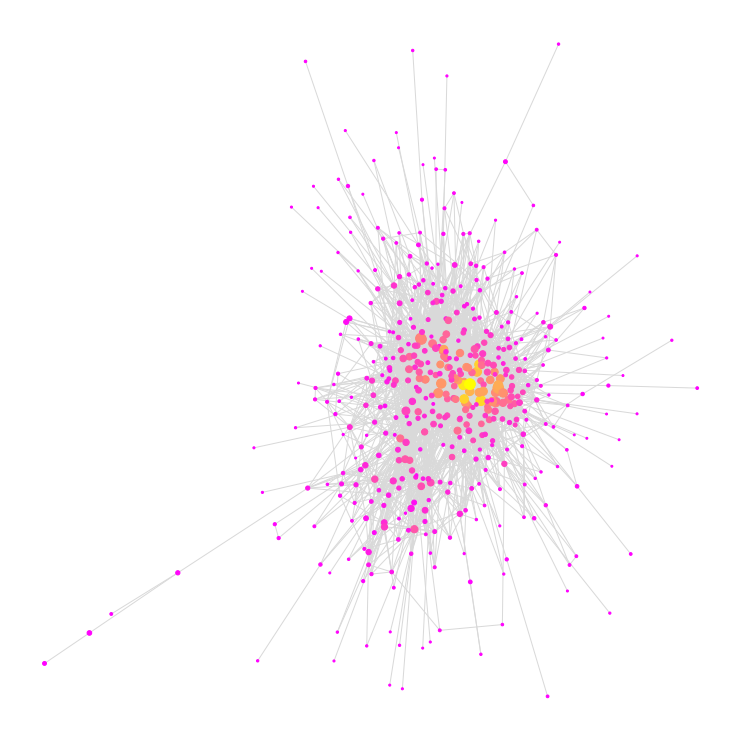

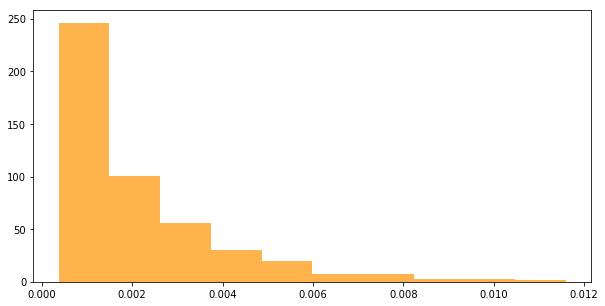

In [97]:
hub_ego = graph
for i, metric in enumerate([pagerank]):
    fig = plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_size=[metric[v] * 10000 for v in hub_ego], with_labels=False, 
            node_color=[len(hub_ego[v]) for v in hub_ego], cmap=plt.cm.spring, edge_color='0.85')
    fig.savefig('pdf/metrics/' + PREF + '_page_rank.pdf')
    fig = plt.figure(figsize=(10, 5))
    plt.hist(list(metric.values()), color=plt.cm.spring(0.7))
    fig.savefig('pdf/histograms/' + PREF + '_metric_' + str(i) +'.pdf')

In [99]:
#### Centralities top

In [109]:
bc = list(reversed(sorted([(betweenness_centrality[key], graph.nodes[key]['name']) for key in betweenness_centrality])))[:10]
dc = list(reversed(sorted([(degree_centrality[key], graph.nodes[key]['name']) for key in degree_centrality])))[:10]
cc = list(reversed(sorted([(closeness_centrality[key], graph.nodes[key]['name']) for key in closeness_centrality])))[:10]

In [117]:
bc_top = [x[1] for x in bc]
dc_top = [x[1] for x in dc]
cc_top = [x[1] for x in cc]

In [123]:
top = pd.DataFrame([bc_top, dc_top, cc_top]).values.T

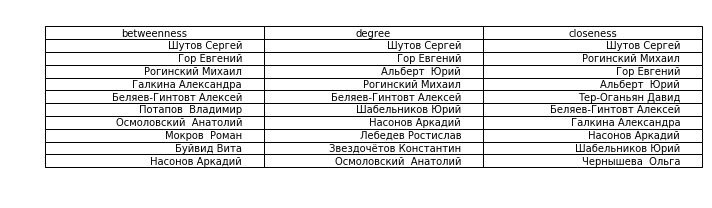

In [130]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.axis('off')
ax.axis('tight')
cm = plt.cm.Wistia
ax.table(cellText=top,
         colLabels=['betweenness', 'degree', 'closeness'], loc='center')

fig.tight_layout()
plt.show()
fig.savefig('pdf/tables/' + PREF + 'centrality_table.pdf')

In [ ]:
[betweenness_centrality, degree_centrality, closeness_centrality]

In [31]:
nx.write_gexf(graph, 'gexf/' + PREF + '_stats_graph.gexf')

### Assortativity mixing

In [32]:
from networkx.algorithms.assortativity import mixing as nx_mixing

### Node similarity

In [33]:
import networkx.algorithms.similarity as nx_similarity # NEED SIMRANK

## Community detection

### Cliques

In [34]:
from networkx.algorithms.clique import find_cliques

In [35]:
cliques = list(find_cliques(graph))

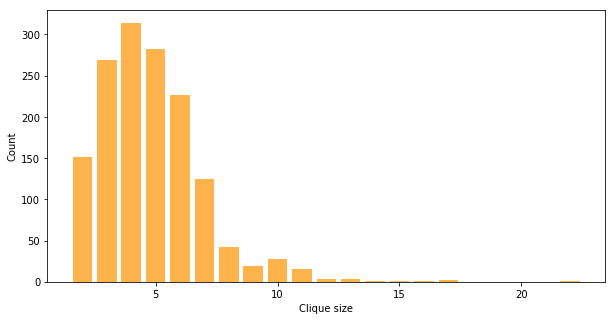

In [36]:
clique_size = []
clique_count = []
for i in range(40):
    if len(list(filter(lambda x: len(x) == i, cliques))):
        clique_size.append(i)
        clique_count.append(len(list(filter(lambda x: len(x) == i, cliques))))
        
fig = plt.figure(figsize=(10, 5))
plt.bar(clique_size, clique_count, width=0.80, color=plt.cm.spring(0.7))

plt.ylabel("Count")
plt.xlabel("Clique size")
#plt.yscale('log')
fig.savefig('pdf/histograms/' + PREF + '_clique_hist.pdf')

In [87]:
cliques = list(find_cliques(graph))
i = 22
cnt = 1
clique_graph = graph
nx.set_node_attributes(graph, 0, 'clique')
while len(list(filter(lambda x: len(x) >= 10, cliques))) > 0:
    if len(list(filter(lambda x: len(x) == i, cliques))) == 0:
        i -= 1
    else:
        for subg in list(filter(lambda x: len(x) == i, cliques)):
            nodes = set(clique_graph.nodes) - set(subg)
            clique_graph = clique_graph.subgraph(list(nodes))
            nx.set_node_attributes(graph, dict([(key, cnt) for key in subg]), 'clique')
            cnt += 1
        cliques = list(find_cliques(clique_graph))

### K-cores

In [70]:
from networkx.algorithms.core import core_number

In [71]:
k_cores = core_number(graph)
nx.set_node_attributes(graph, k_cores, name='k_cores')
core_color = [-k_cores[v] for v in graph.node]

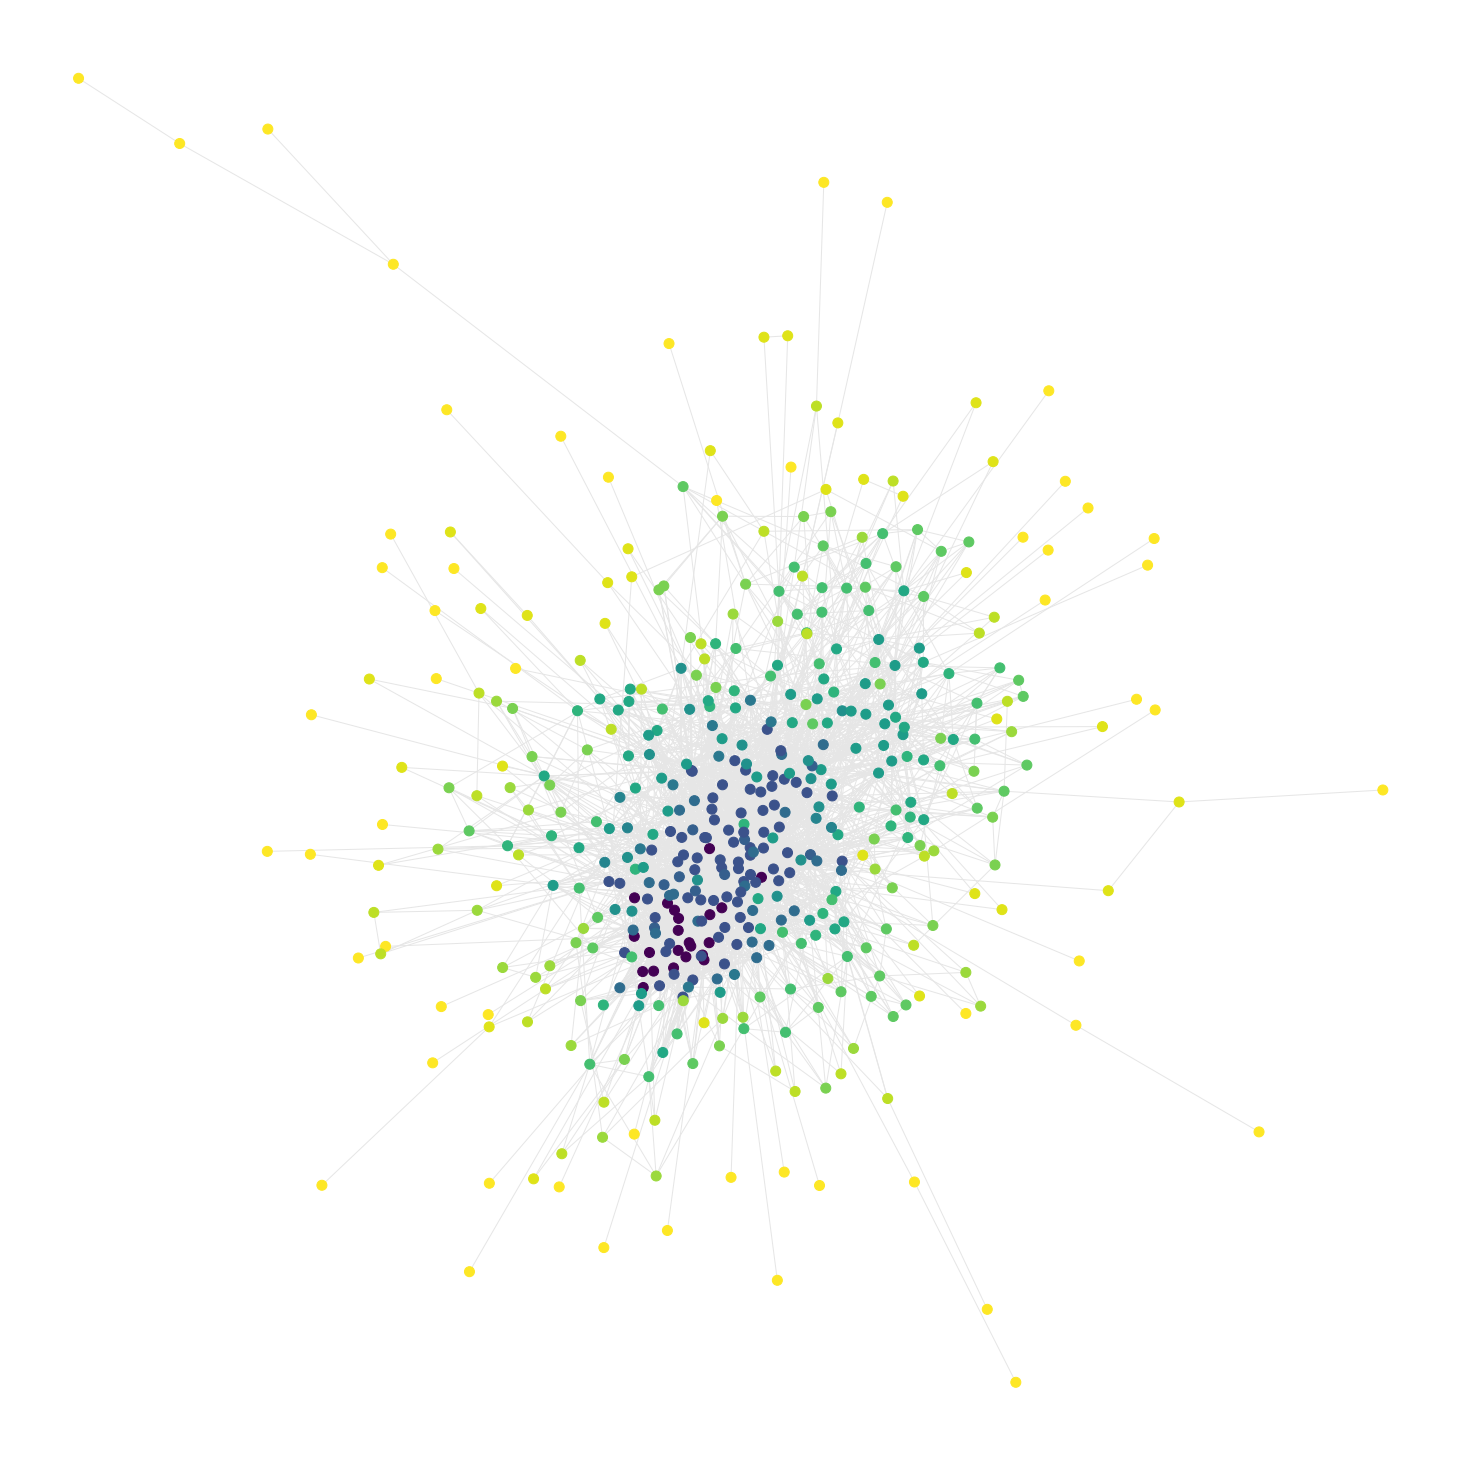

In [72]:
fig = plt.figure(figsize=(20, 20))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size=100, with_labels=False, 
        node_color=core_color, node_cmap=plt.cm.spring,
        edge_color='0.9')
fig.savefig('pdf/graphs/' + PREF + '_k_cores.pdf')

### Modularity optimization clustering

In [42]:
import numpy as np

In [43]:
from networkx.algorithms.community import greedy_modularity_communities
subgraph = list(greedy_modularity_communities(graph))

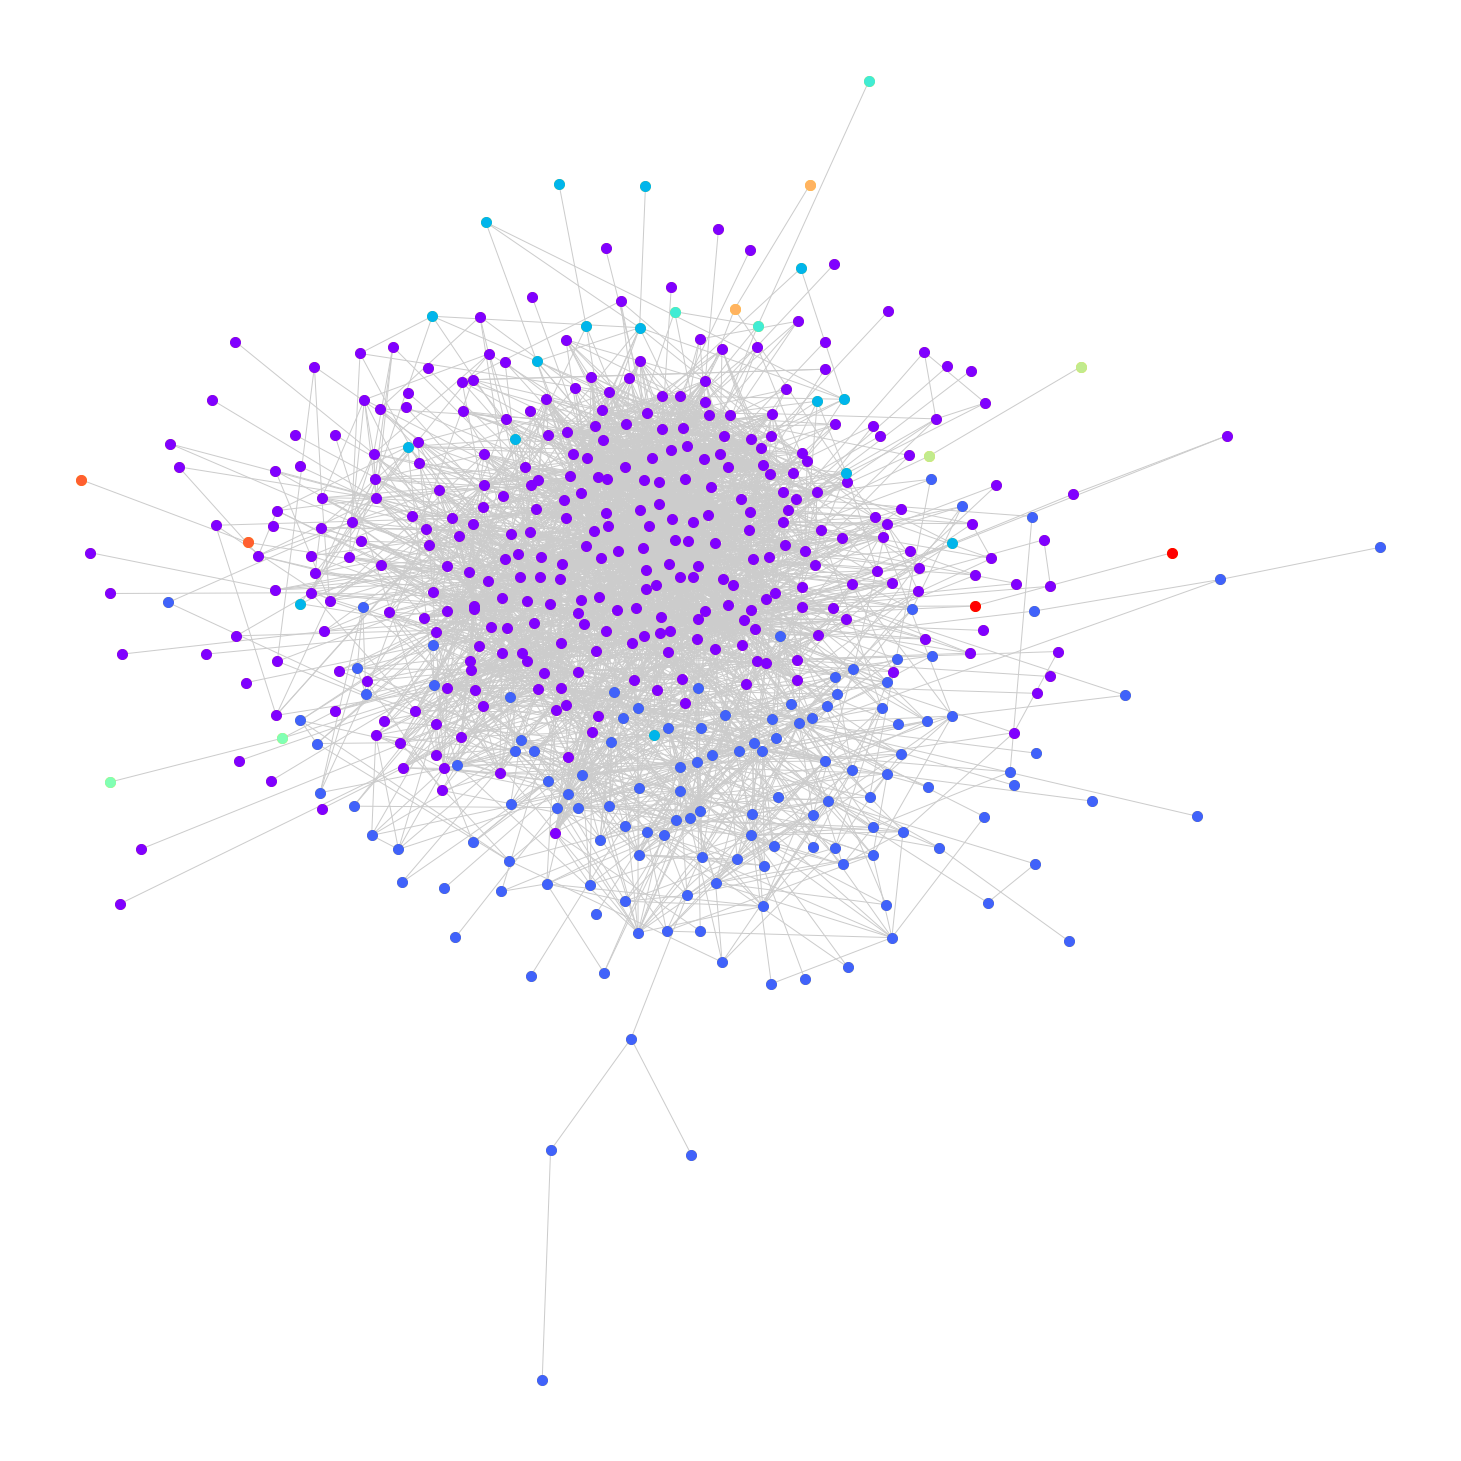

In [45]:
fig = plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, with_labels=False, node_color=plt.cm.spring(0.85), edge_color='0.8')
colors = np.linspace(0, 1, len(subgraph))
for i, community in enumerate(subgraph):
    nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=100, node_color=plt.cm.rainbow(colors[i]))
    nx.set_node_attributes(graph, dict([(item, i) for item in community]), 'modularity')
fig.savefig('pdf/graphs/' + PREF + '_modularity_community.pdf')

In [89]:
nx.write_gexf(graph, 'gexf/' + PREF + '_stats_graph.gexf')

#### Betweenness Centrality Clustering 

In [60]:
from networkx.algorithms.community.centrality import girvan_newman

In [61]:
def valuable_edge(graph):
    max_edge = None
    for edge in graph.edges:
        if max_edge is None or graph.edges[edge]['weight'] > graph.edges[max_edge]['weight']:
            max_edge = edge
    return max_edge

In [62]:
generator = girvan_newman(graph) #, most_valuable_edge=valuable_edge)

In [63]:
import itertools
k = 5
for i in range(k):
    subgraph = next(generator)

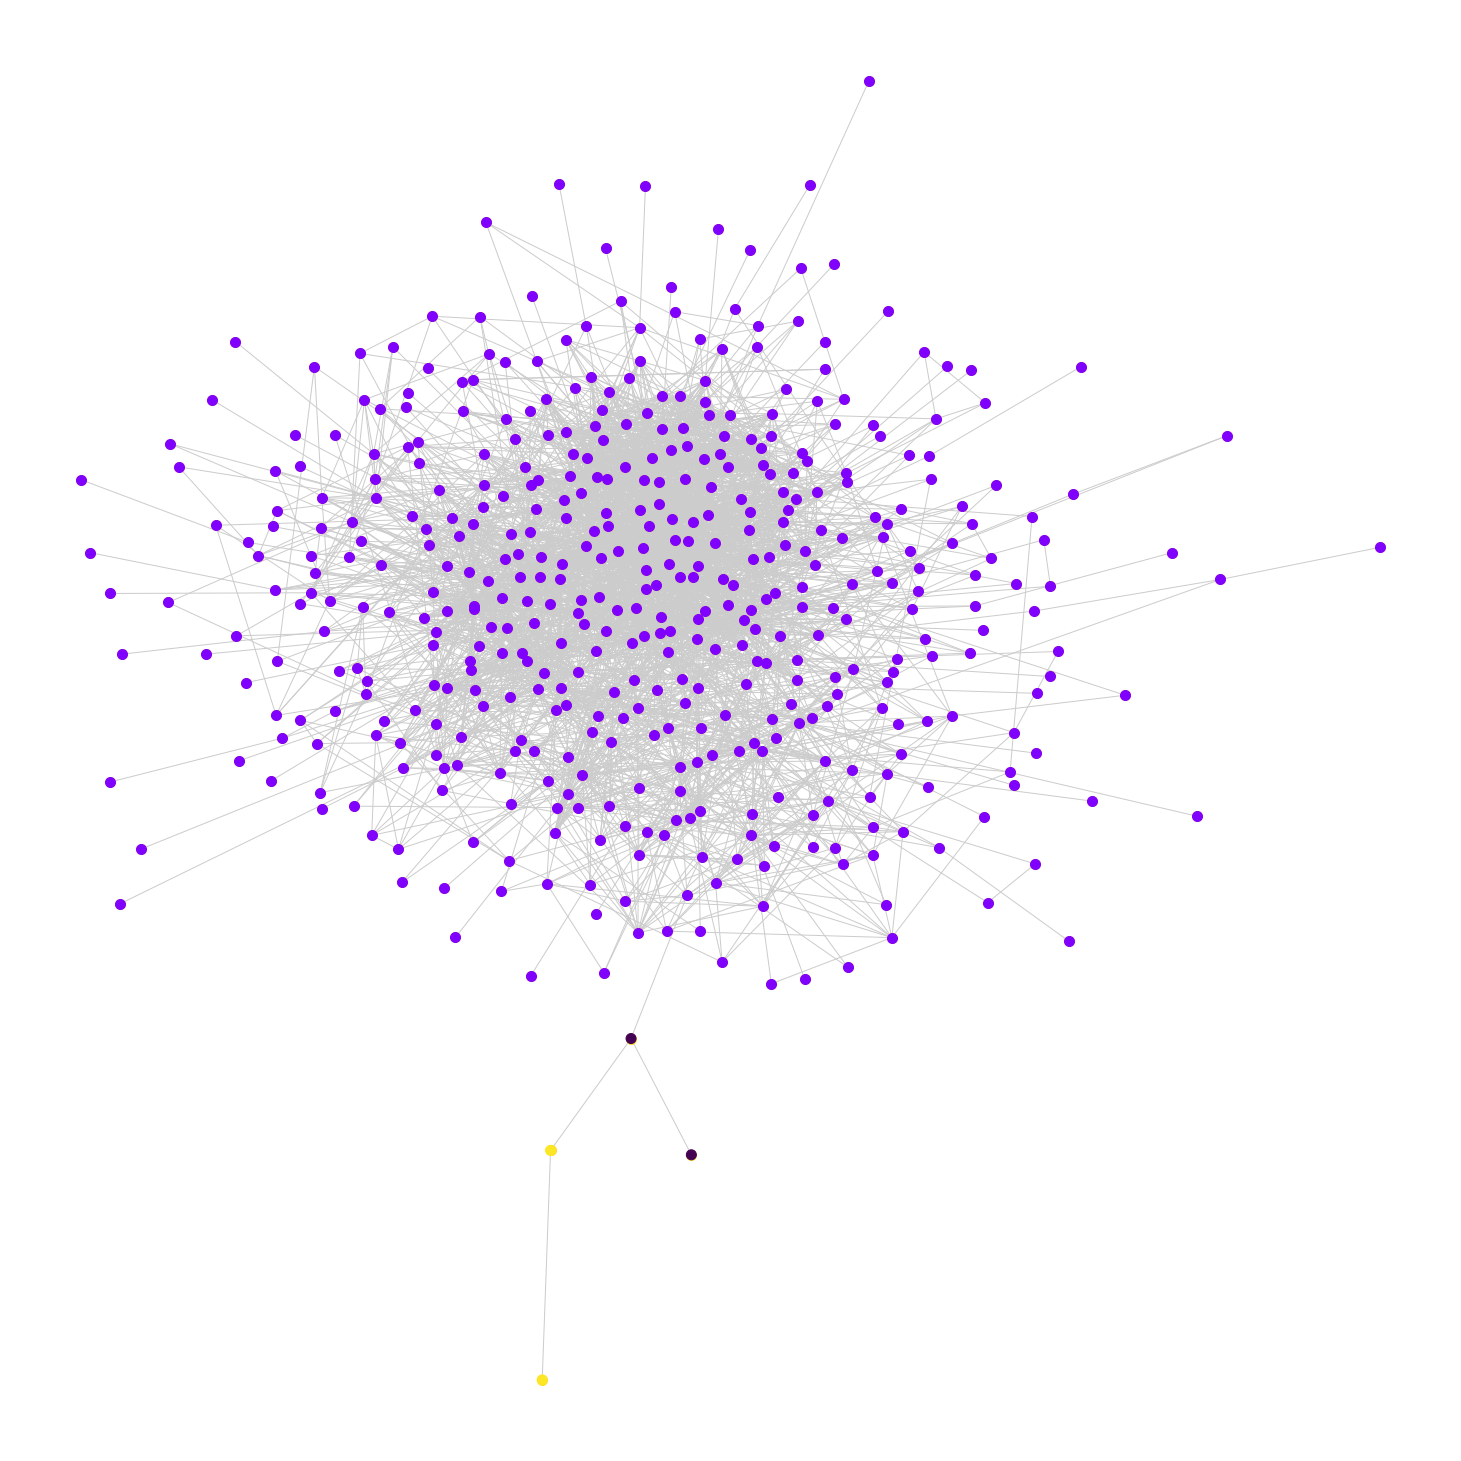

In [51]:
fig = plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, with_labels=False, node_color=plt.cm.spring(0.85), edge_color='0.8')
colors = np.linspace(0, 1, len(subgraph))
for i, community in enumerate(subgraph):
    nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=100, node_color=plt.cm.rainbow(colors[i]))
fig.savefig('pdf/graphs/' + PREF +'_girvan_community.pdf')

#### Label Propagation Community

In [52]:
from networkx.algorithms.community.label_propagation import label_propagation_communities

In [53]:
generator = label_propagation_communities(graph)
k = 7

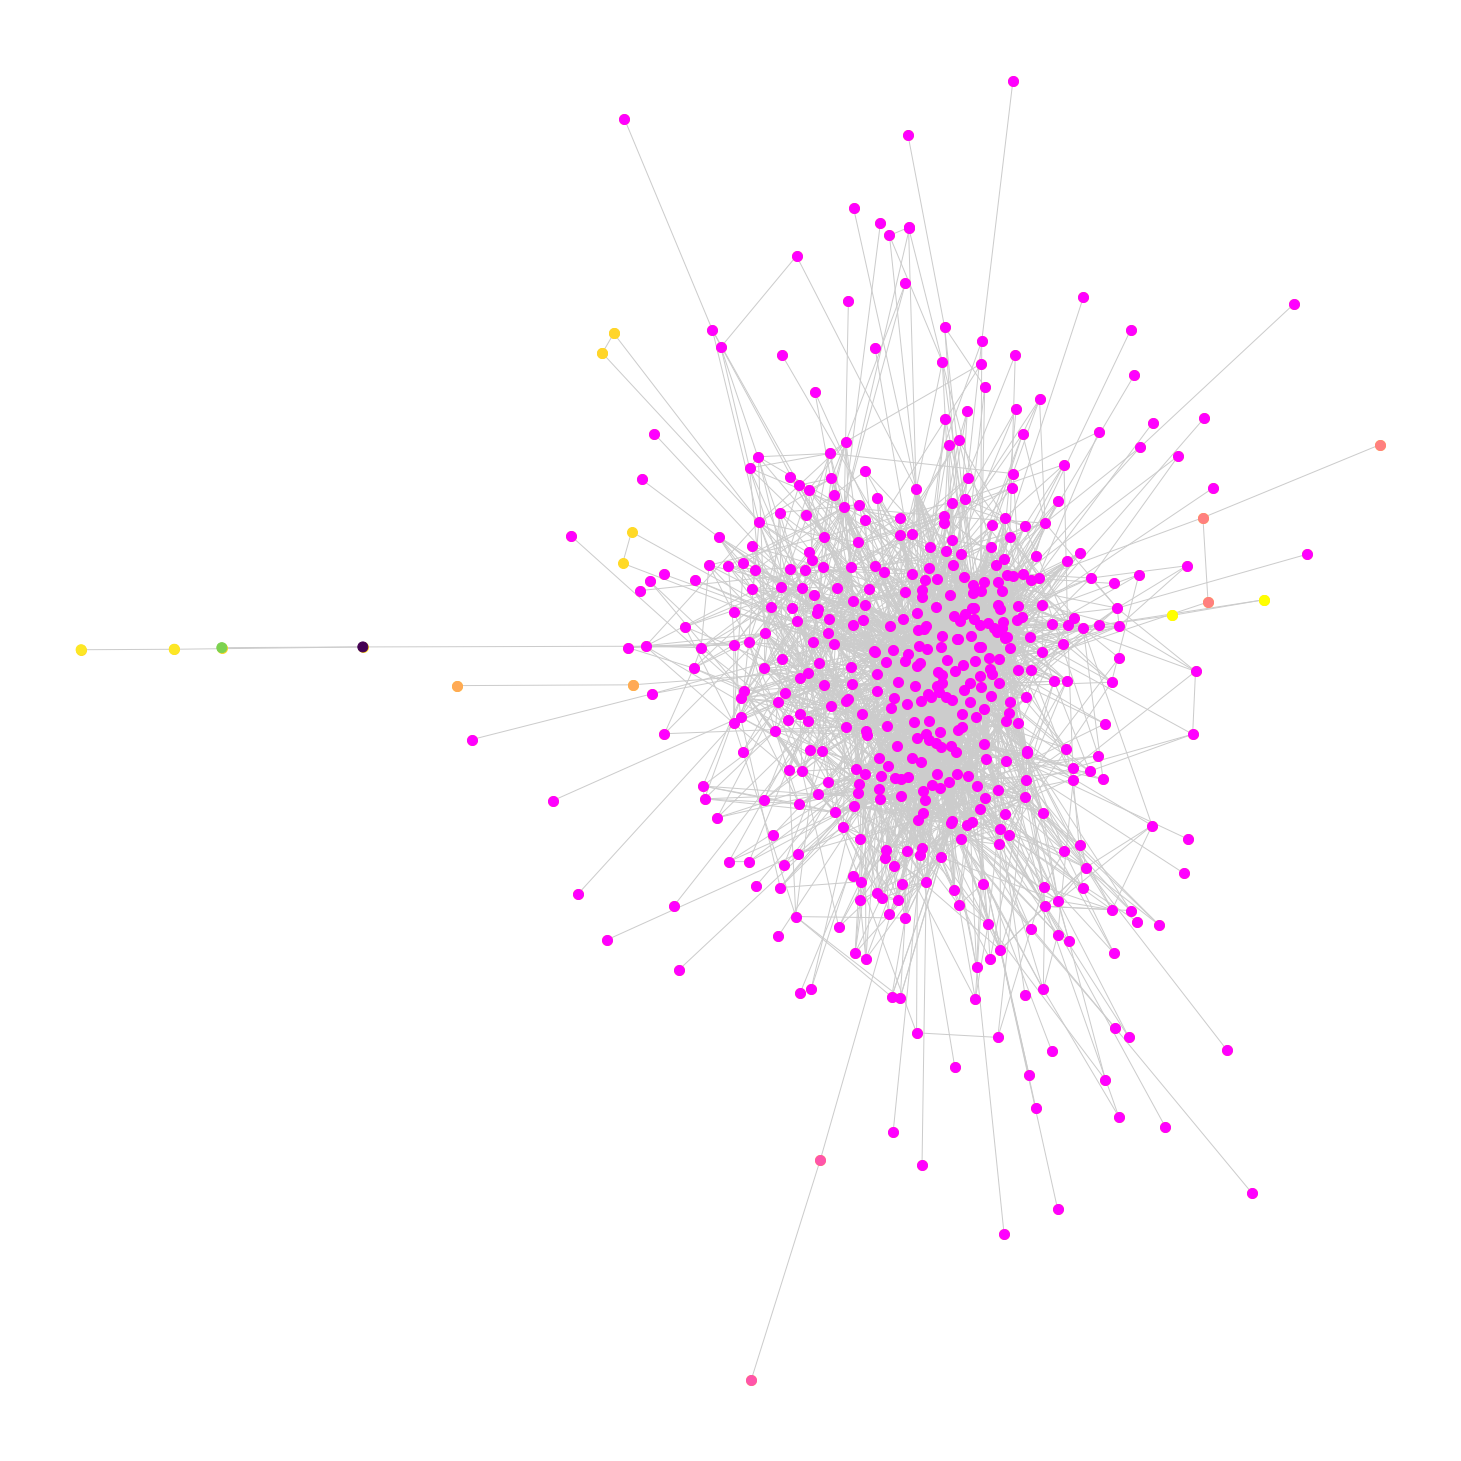

In [54]:
fig = plt.figure(figsize=(20, 20))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size=100, with_labels=False, node_color=plt.cm.spring(0.85), edge_color='0.8')
colors = np.linspace(0, 1, k)
for i in range(k):
    community = next(generator)
    nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=100, node_color=plt.cm.spring(colors[i]))
fig.savefig('pdf/graphs/' + PREF + '_label_prop_community.pdf')

#### Spectral clustering

In [55]:
from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict
import numpy

In [56]:
def create_hc(G):
    path_length = nx.all_pairs_shortest_path_length(G)
    dict_idx = dict([(v, i) for i, v in enumerate(G)])
    reverse_idx = dict([(dict_idx[v], v) for v in dict_idx])
    distances = numpy.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[dict_idx[u], dict_idx[v]] = d
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)
    membership = list(hierarchy.fcluster(Z, t=10, criterion='maxclust'))
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    res = list(partition.values())
    return [[reverse_idx[v] for v in community] for community in res]

In [57]:
partitions = create_hc(graph)

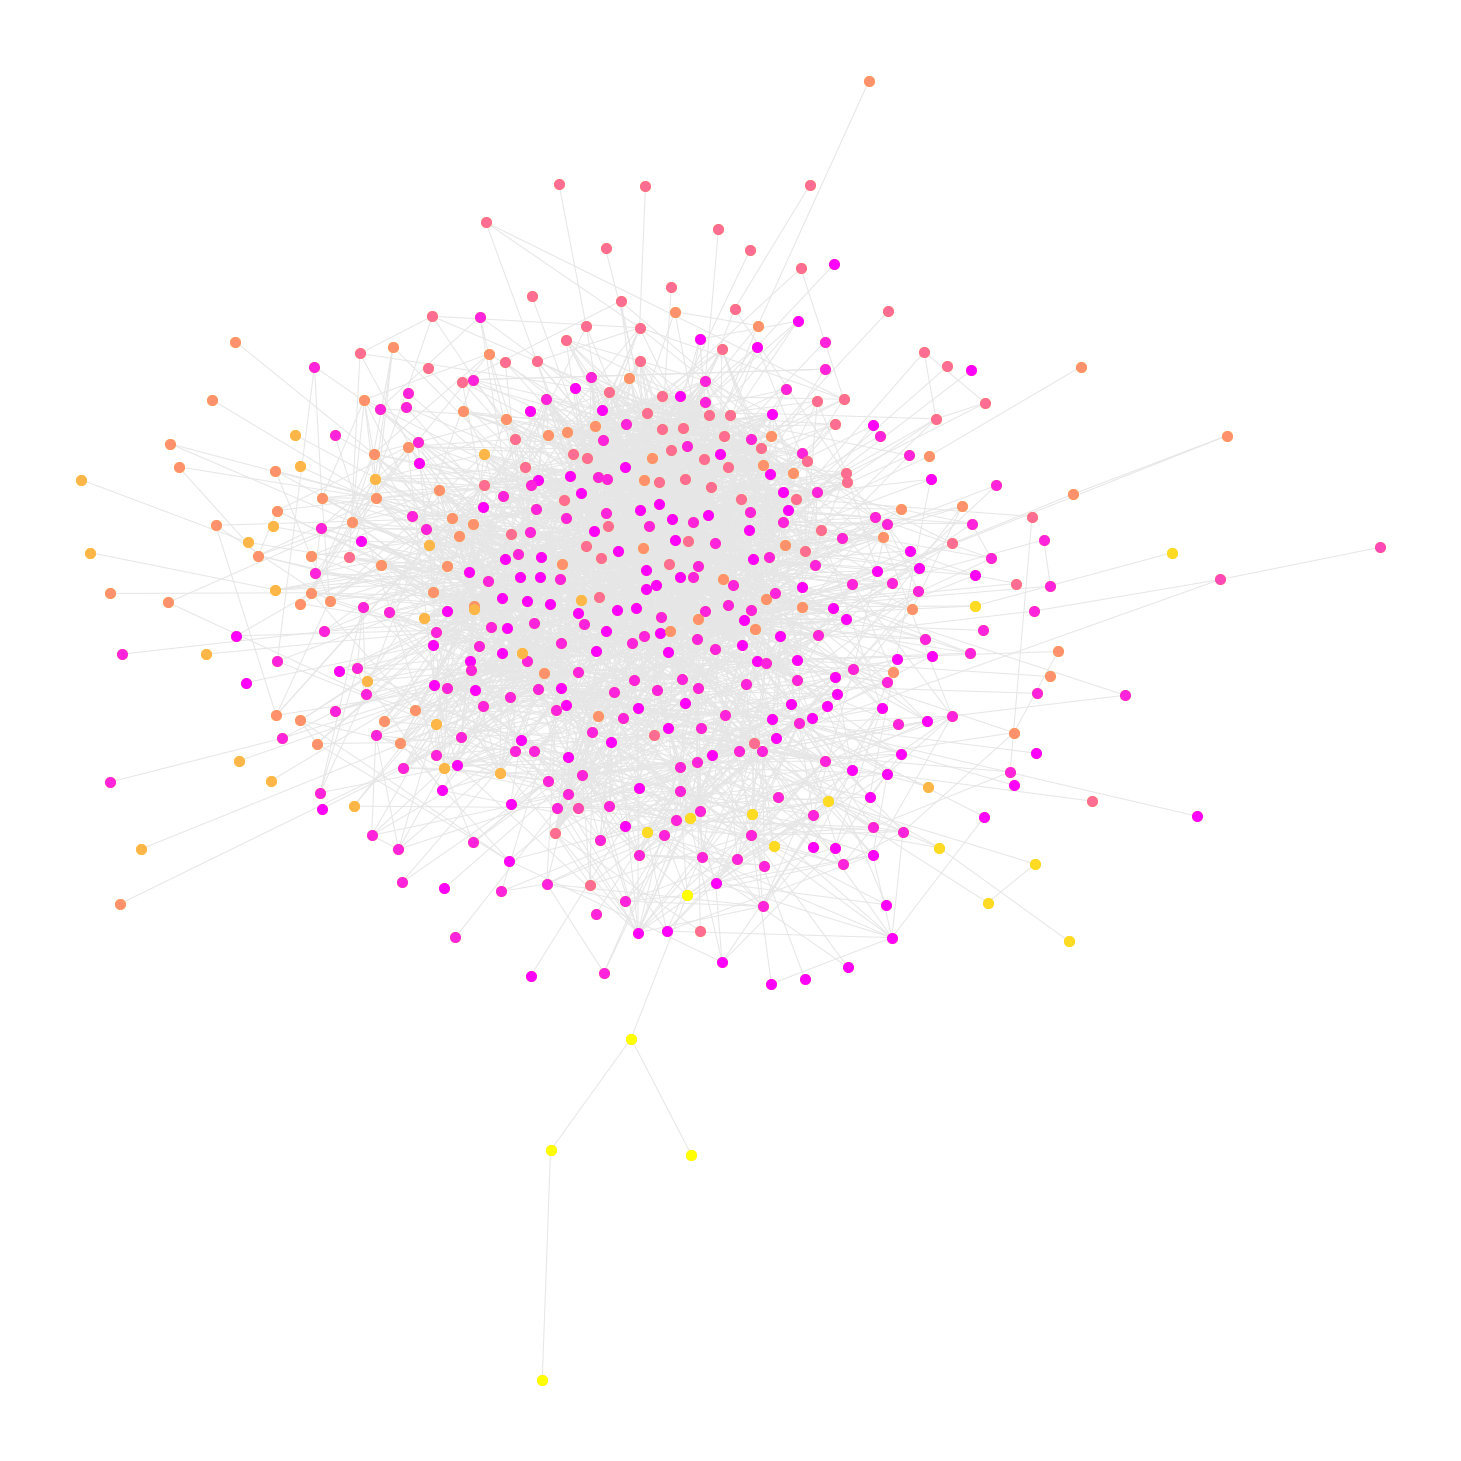

In [58]:
fig = plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, with_labels=False, node_color=plt.cm.spring(0.85), edge_color='0.9')
colors = np.linspace(0, 1, len(partitions))
for i, community in enumerate(partitions):
    nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=100, node_color=plt.cm.spring(colors[i]))
    nx.set_node_attributes(graph, dict([(item, i) for item in community]), 'hier_clust')

fig.savefig('pdf/graphs/' + PREF + '_hier_clustering_community.pdf')